In [28]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt

## Gram-Schmidt for conjugate directions

$$\begin{align}
v_i = u_i + \sum_{j = 1}^{i - 1} \beta_{ij} v_j.
\end{align}$$

where $v_0 = u_0$ and $\beta_{ij}$ are appropriately chosen constants such that $d_i A d_j = 0$ whenever $i \neq j$

$$\begin{align}
\beta_{ij} = - \frac{u_i^\top A v_j}{v_j^\top A v_j}.
\end{align}$$

In [84]:
def quadratic_form(x, mean, cov):
    
    diff = x - mean
    prec_diff = tf.linalg.solve(cov, diff)
    quad = - 0.5 * tf.reduce_sum(diff * prec_diff, axis=0)
    
    return quad

def quad_log_prob(x, mean, cov):
    
    with tf.GradientTape() as tape:
        
        tape.watch(x)
        
        log_prob = quadratic_form(x, mean, cov)
        
    gradients = tape.gradient(log_prob, x)
    
    return log_prob, gradients
        
    

def cond_log_prob(unnorm_log_prob, x0, d):
    return lambda x : unnorm_log_prob(x0 + x * d)

In [ ]:
class cgcs_kernel(tfp.mcmc.TransitionKernel):
    
    def __init__(self, log_prob):
        
        super().__init__()
        
        self.log_prob
        self.epsilon = 1e-6
        
    
    def is_calibrated(self):
        return True
    
    
    def one_step(self, current_state, previous_kernel_results, seed=None):
        pass
    
    
    def orthogonalise_by_gram_schmidt(self, d, D, AD):
        
        DTAD = tf.matmul(D, AD, transpose_a=True)
        DTAd = tf.matmul(AD, d, transpose_a=True)
        a = - tf.linalg.inv(DTDA, DTAd)
        
        d_ = d + np.matmul(D, a)
        
        return d_
    
        
    def grad_hessian_products(self, d_hist):
        log_prob, dlog_prob = self.log_prob(d_)
        pass

In [65]:
cgcs_kernel()

In [88]:
x = tf.ones((2, 1))
mean = tf.zeros((2, 1))
cov = tf.convert_to_tensor([[1.0, 0.],
                            [0., 1.0]])

quad_log_prob(x, mean, cov)

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-1.],
        [-1.]], dtype=float32)>)

In [48]:
num_results = 10
init_state = tf.ones((2, 1))
mean = tf.zeros((2, 1))
cov = tf.convert_to_tensor([[1.0, 0.5],
                            [0.5, 1.0]])

log_prob = lambda x : quadratic_form(x, mean, cov)

states = tfp.mcmc.sample_chain(num_results=num_results,
                               current_state=init_state,
                               kernel=tfp.mcmc.SliceSampler(target_log_prob_fn=log_prob,
                                                            step_size=1.0,
                                                            max_doublings=5),
                               num_burnin_steps=0,
                               num_steps_between_results=1,
                               trace_fn=None)

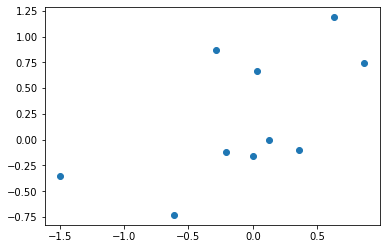

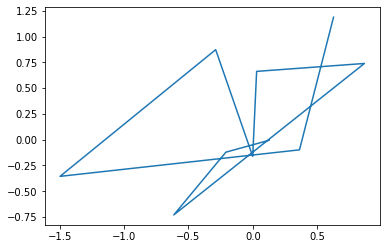

In [49]:
states_ = np.array(states)[:, :, 0]

plt.scatter(states_[:, 0], states_[:, 1])
plt.show()
plt.plot(states_[:, 0], states_[:, 1])
plt.show()

In [92]:
_ih[-30:]

['cgcs_kernel()',
 'class cgcs_kernel(tfp.mcmc.TransitionKernel):\n    \n    def __init__(self):\n        \n        super().__init__()\n        \n    \n    def is_calibrated(self):\n        return True\n    \n    def one_step(current_state, previous_kernel_results, seed=None):\n        pass',
 'cgcs_kernel()',
 'class cgcs_kernel(tfp.mcmc.TransitionKernel):\n    \n    def __init__(self, log_prob):\n        \n        super().__init__()\n        \n        self.log_prob\n        self.epsilon = 1e-6\n        \n    \n    def is_calibrated(self):\n        return True\n    \n    \n    def one_step(self, current_state, previous_kernel_results, seed=None):\n        pass\n    \n    \n    def orthogonalise_by_gram_schmidt(self, d, D, AD):\n        \n        DTAD = tf.matmul(D, AD, transpose_a=True)\n        \n        a = - tf.linalg.inv(DTDA, )\n        \n    def grad_hessian_products(self, d_hist):\n        log_prob, dlog_prob = self.log_prob(d_)\n        pass',
 'tf.repeat',
 'help(tf.repeat)',

In [95]:
print("'class cgcs_kernel(tfp.mcmc.TransitionKernel):\n    \n    def __init__(self, log_prob):\n        \n        super().__init__()\n        \n        self.log_prob\n        self.epsilon = 1e-6\n        \n    \n    def is_calibrated(self):\n        return True\n    \n    \n    def one_step(self, current_state, previous_kernel_results, seed=None):\n        pass\n    \n    \n    def orthogonalise_by_gram_schmidt(self, d, D, AD):\n        \n        DTAD = tf.matmul(D, AD, transpose_a=True)\n        \n        a = - tf.linalg.inv(DTDA, )\n        \n    def grad_hessian_products(self, d_hist):\n        log_prob, dlog_prob = self.log_prob(d_)\n        pass")

'class cgcs_kernel(tfp.mcmc.TransitionKernel):
    
    def __init__(self, log_prob):
        
        super().__init__()
        
        self.log_prob
        self.epsilon = 1e-6
        
    
    def is_calibrated(self):
        return True
    
    
    def one_step(self, current_state, previous_kernel_results, seed=None):
        pass
    
    
    def orthogonalise_by_gram_schmidt(self, d, D, AD):
        
        DTAD = tf.matmul(D, AD, transpose_a=True)
        
        a = - tf.linalg.inv(DTDA, )
        
    def grad_hessian_products(self, d_hist):
        log_prob, dlog_prob = self.log_prob(d_)
        pass
